In [2]:
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import polyflexmd.data_analysis.plot.msd as msd_plot
import polyflexmd.data_analysis.theory.rouse as rouse
import polyflexmd.data_analysis.transform.msdlm as transform_msdlm
import polyflexmd.data_analysis.plot.utils as plot_utils
import pathlib

from scipy.signal import savgol_filter

%load_ext autoreload
%autoreload 2

sns.set_style("darkgrid")

sns.set_style("darkgrid")

params = {
    'axes.labelsize': 10,
    'figure.dpi': 300,
    "figure.figsize": plot_utils.get_figure_size(width=1, n_rows=1)
}

plt.rcParams.update(params)

In [3]:
def read_msd_lm_df(path):
    df_msd_lm = pd.read_csv(path)
    df_msd_lm["t/LJ"] = df_msd_lm["t"] * 0.0025
    df_msd_lm["t/LJ"] = df_msd_lm["t/LJ"] - df_msd_lm["t/LJ"].min()
    return df_msd_lm.loc[df_msd_lm["t/LJ"] >= 1].copy()

def with_msdlm_bin_avg(df_msdlm: pd.DataFrame, bin_size: int = 100):
    bins = np.linspace(df_msdlm.index.min(), df_msdlm.index.max(), num=df_msdlm.shape[0] // bin_size)
    binned_idx = pd.cut(df_msdlm.index, bins)
    binned_msdlm_avg = df_msdlm.groupby(binned_idx).agg({
        "dr_N^2": "mean",
        "delta dr_N^2": "mean",
        "t/LJ": lambda ts: ts.min() + (ts.max() - ts.min())/2
    })
    return binned_msdlm_avg.set_index("t/LJ")

def with_savgol(df_msdlm: pd.DataFrame, window_size: int, polyorder: int):
    df_msdlm["dr_N^2"] = savgol_filter(x=df_msdlm["dr_N^2"], window_length=window_size, polyorder=polyorder)
    return df_msdlm

def with_msdlm_ma(df_msdlm: pd.DataFrame, window_size: int = 10, window_type="hamming"):
    df_msdlm["dr_N^2"] = df_msdlm["dr_N^2"].rolling(window_size, min_periods=1, win_type=window_type).mean()
    return df_msdlm.dropna()

def get_ete_mean(path):
    df_ete = pd.read_csv(path)

    def calc_mean_R(df):
        R = 0
        for dim in ["x", "y", "z"]:
            R += (df[f"R_{dim}"] ** 2).mean()
        return R

    return df_ete.groupby("t").apply(calc_mean_R).rename("R^2")

def smooth(x,window_len=11,window='hanning'):
    if window_len<3:
        return x

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [43]:
N = 63
zeta = 1
b = .97
L_contour = N * b

experiments = [
    {
        "n": 17,
        "path": pathlib.Path(
            "/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K/17-EEA1_short-free_chain/ef6e4e76"),
        "zeta_e": 1.0,
        "l_K": 6.02,
        "label": "$l_K/L=6.02$, $\\zeta_e=1$"
    },
    {
        "n": 18,
        "path": pathlib.Path(
            "/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K-vary-d_end/18-EEA1_short+Rab5_10x-free_chain/ef6e4e76"),
        "zeta_e": 10.0,
        "l_K": 6.02,
        "label": "$l_K/L=6.02$, $\\zeta_e=10$"
    },
    {
        "n": 19,
        "path": pathlib.Path(
            "/beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K/19-EEA1_short-lp_bonded_like-free_chain/ef6e4e76"),
        "zeta_e": 1.0,
        "l_K": 0.6,
        "label": "$l_K/L=0.6$, $\\zeta_e=1$"
    },
]

for experiment in experiments:
    print(f"Reading {experiment['path']}...")
    experiment["df_msdlm raw"] = read_msd_lm_df(experiment["path"] / "data" / "processed" / "lm_msd.csv")
    df = experiment["df_msdlm raw"]
    print(df.columns)
    df = df.groupby((df["t"] % 100 == 0).cumsum(), as_index=False).agg({
        "t": "min",
        "dr_N^2": "mean",
        "delta dr_N^2": "mean",
        "t/LJ": "min",
    })
    experiment["df_msdlm raw"] = df

Reading /beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K/17-EEA1_short-free_chain/ef6e4e76...
Index(['t', 'dr_N^2', 'delta dr_N^2', 'kappa', 't/LJ'], dtype='object')
Reading /beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K-vary-d_end/18-EEA1_short+Rab5_10x-free_chain/ef6e4e76...
Index(['t', 'dr_N^2', 'delta dr_N^2', 'kappa', 'd_end', 't/LJ'], dtype='object')
Reading /beegfs/ws/0/s4610340-polyflexmd/data/experiment_results/FENE-beadspring-free_chain-vary-l_K/19-EEA1_short-lp_bonded_like-free_chain/ef6e4e76...
Index(['t', 'dr_N^2', 'delta dr_N^2', 'kappa', 't/LJ'], dtype='object')


In [44]:
experiments[0]["df_msdlm raw"]

,t,dr_N^2,delta dr_N^2,t/LJ
0,35000400,0.749257,0.085347,1.00
1,35000500,0.953194,0.113249,1.25
2,35000600,1.199974,0.154224,1.50
3,35000700,1.424399,0.187664,1.75
4,35000800,1.650504,0.219467,2.00
...,...,...,...,...
80072,835000000,177831.296875,20730.108959,2000000.00
80073,835010000,178055.265625,20722.272938,2000025.00
80074,835020000,177875.046875,20680.394879,2000050.00
80075,835030000,177852.609375,20689.536903,2000075.00


In [45]:
bin_size = 3
window_size = 10

for experiment in experiments:
    df = experiment["df_msdlm raw"].copy()
    #print("Smoothing ...")
    #with_msdlm_ma(df, window_size=window_size, window_type="exponential")
    #print("Savgol ...")
    #with_savgol(df_msdlm=experiment["df_msdlm"], window_size=10, polyorder=1)
    #print(f"Binavg {experiment['path']}...")
    #df = with_msdlm_bin_avg(df, bin_size=bin_size)
    df.reset_index(inplace=True)
    experiment["df_msdlm"] = df
    # print(f"Reading ete")
    #experiment["df_ete_mean"] = get_ete_mean(experiment["path"] / "data" / "processed" / "ete.csv")

In [46]:
def get_rouse_msdlm_df(ts):
    tau_R = 1 / (3 * np.pi ** 2) * N ** 2 * b ** 2 * zeta
    R = N * b ** 2
    msdlm = rouse.rouse_msdlm(ts, R_sq=R, tau_R=tau_R, N=N)
    df_theor = pd.DataFrame({
        "t/LJ": ts,
        "dr_N^2": msdlm
    })
    return df_theor


df_rouse_msdlm = get_rouse_msdlm_df(experiments[0]["df_msdlm"]["t/LJ"])
df_rouse_msdlm

,t/LJ,dr_N^2
0,1.00,1.751209
1,1.25,1.986880
2,1.50,2.201085
3,1.75,2.399024
4,2.00,2.584085
...,...,...
80072,2000000.00,190495.757189
80073,2000025.00,190498.138141
80074,2000050.00,190500.519094
80075,2000075.00,190502.900046


Plotting 17 ...
Plotting 18 ...
Plotting 19 ...
Plotting 17 ...
Plotting 18 ...
Plotting 19 ...


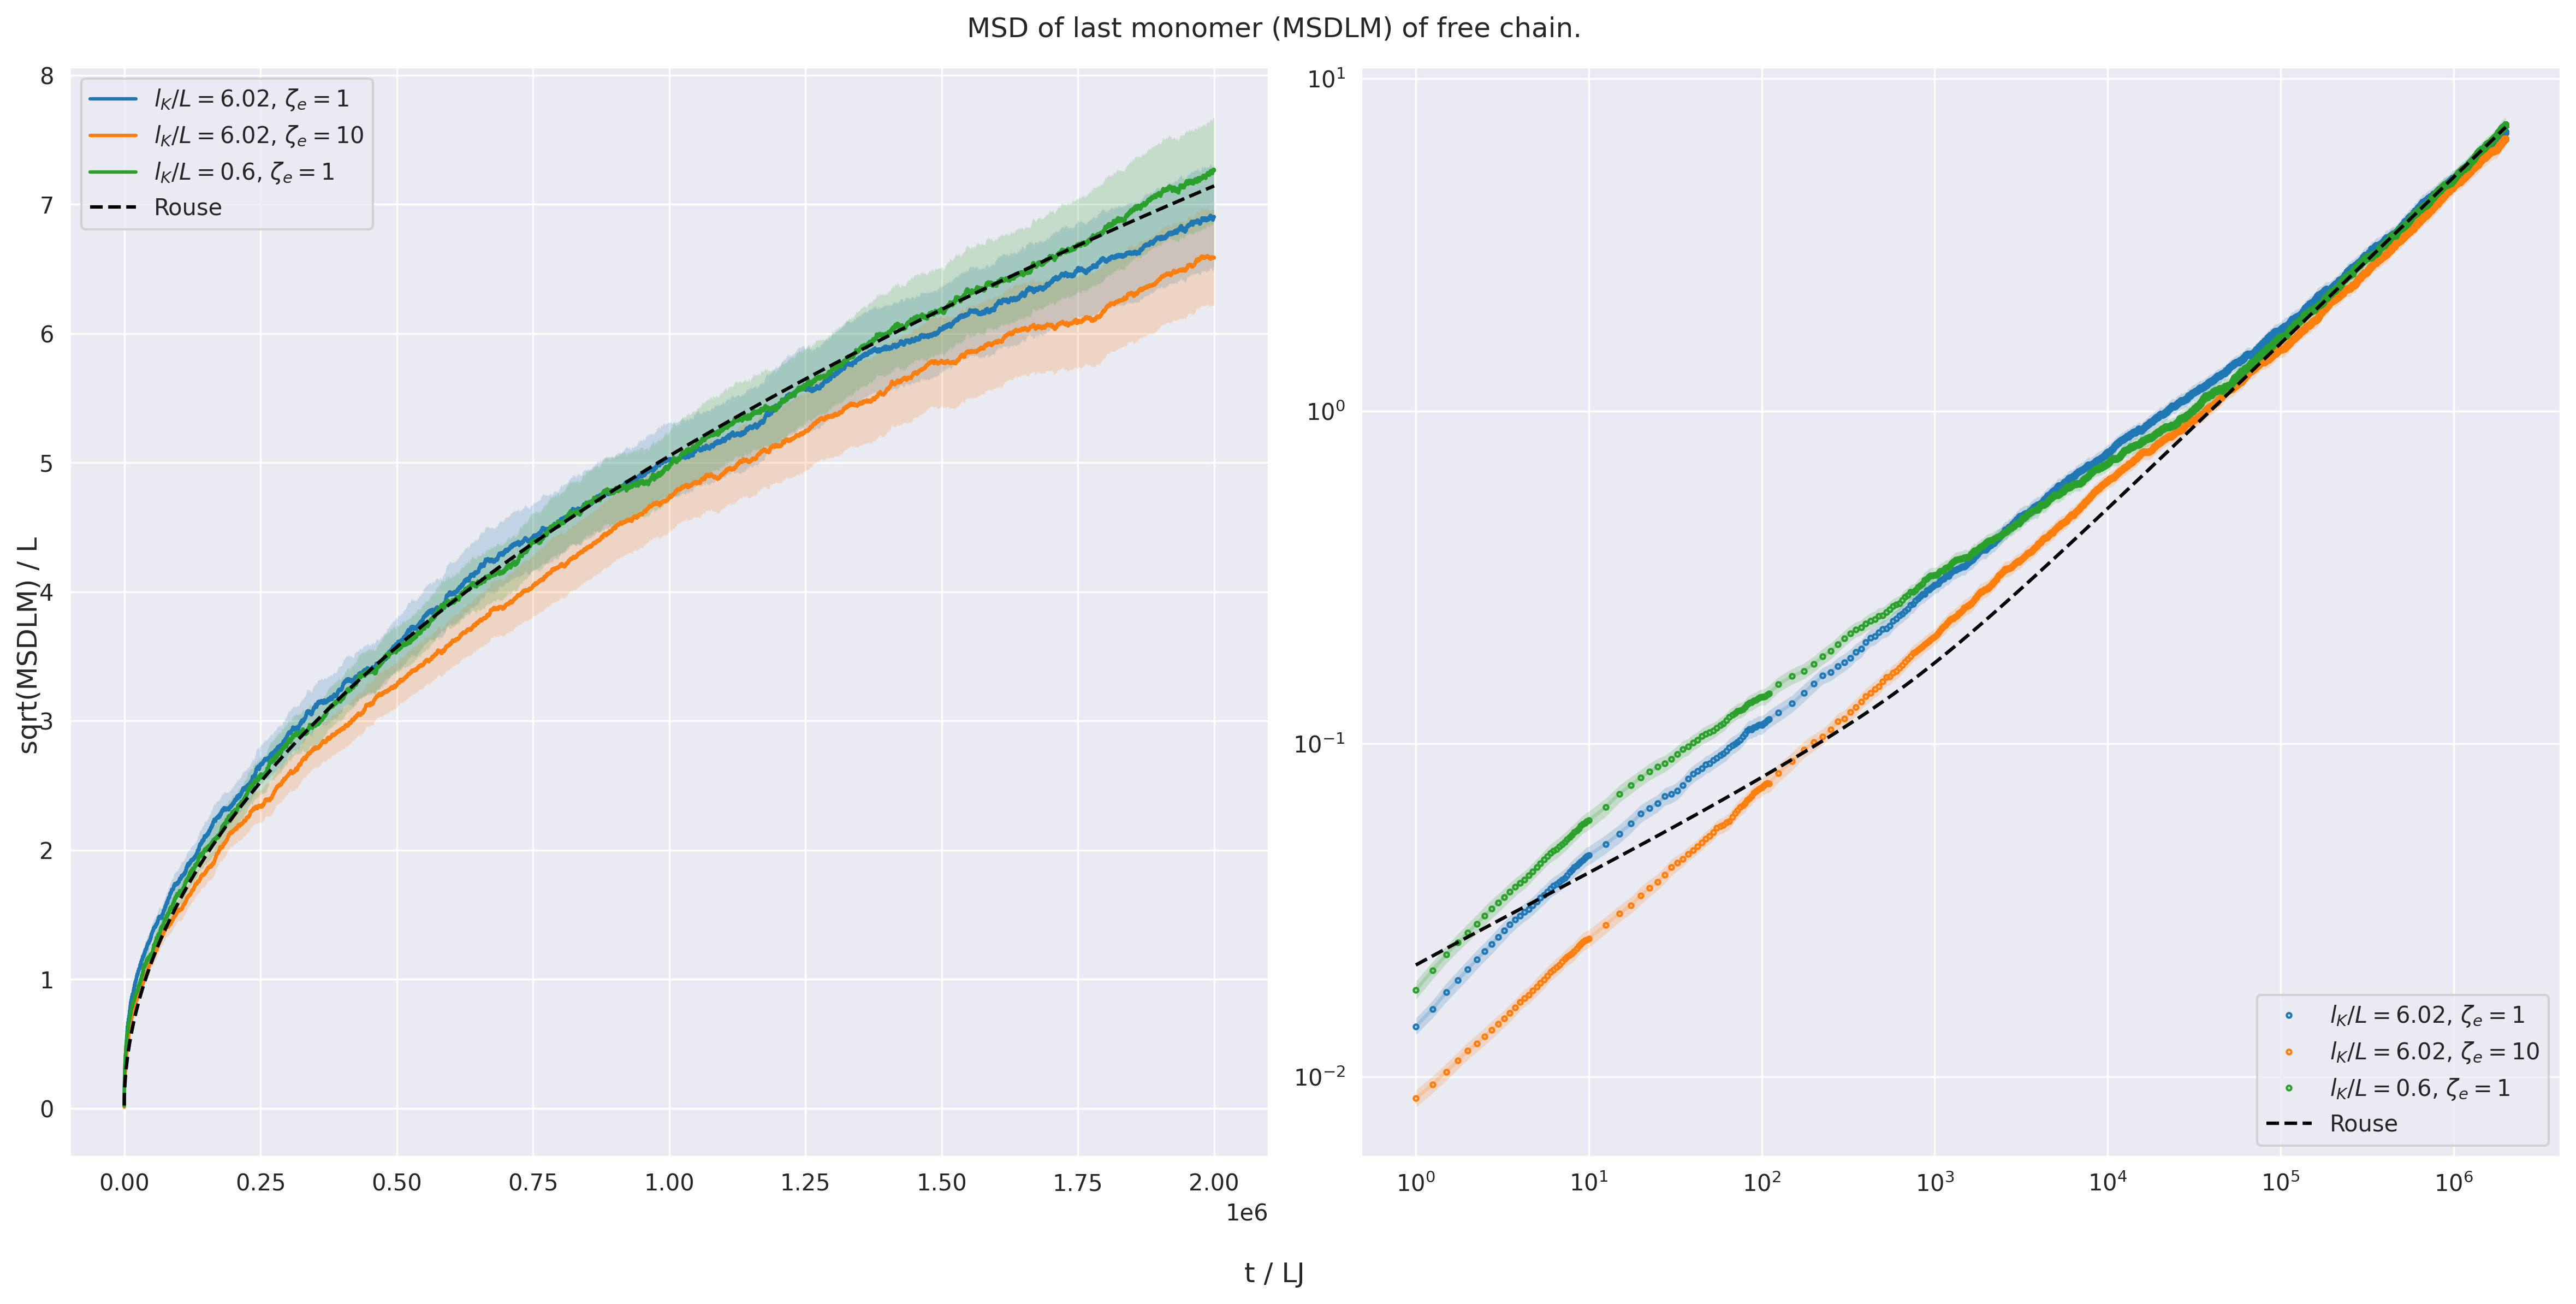

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

for ax, log in zip(axs, [False, True]):

    for experiment, color in zip(experiments, sns.color_palette()):
        
        print(f"Plotting {experiment['n']} ...")
        
        msd_plot.plot_MSD(
            experiment["df_msdlm"],
            log_scale=log,
            l_K=experiment["l_K"],
            L_contour=L_contour,
            zeta=zeta,
            zeta_e=experiment["zeta_e"],
            col="dr_N^2",
            label=experiment["label"],
            ax=ax,
            title="",
            ylabel="",
            xlabel="",
            scatter=log,
            marker_size=2,
            color=color
        )

    ax.plot(df_rouse_msdlm["t/LJ"], np.sqrt(df_rouse_msdlm["dr_N^2"]) / L_contour, label="Rouse", linestyle="--", color="black")
    
    loc = "upper left" if not log else "lower right" 
    
    ax.legend(loc=loc)

fig.suptitle("MSD of last monomer (MSDLM) of free chain.")
fig.supylabel("sqrt(MSDLM) / L")
fig.supxlabel("t / LJ")
fig.tight_layout()

Plotting 17 ...
Plotting 18 ...
Plotting 19 ...


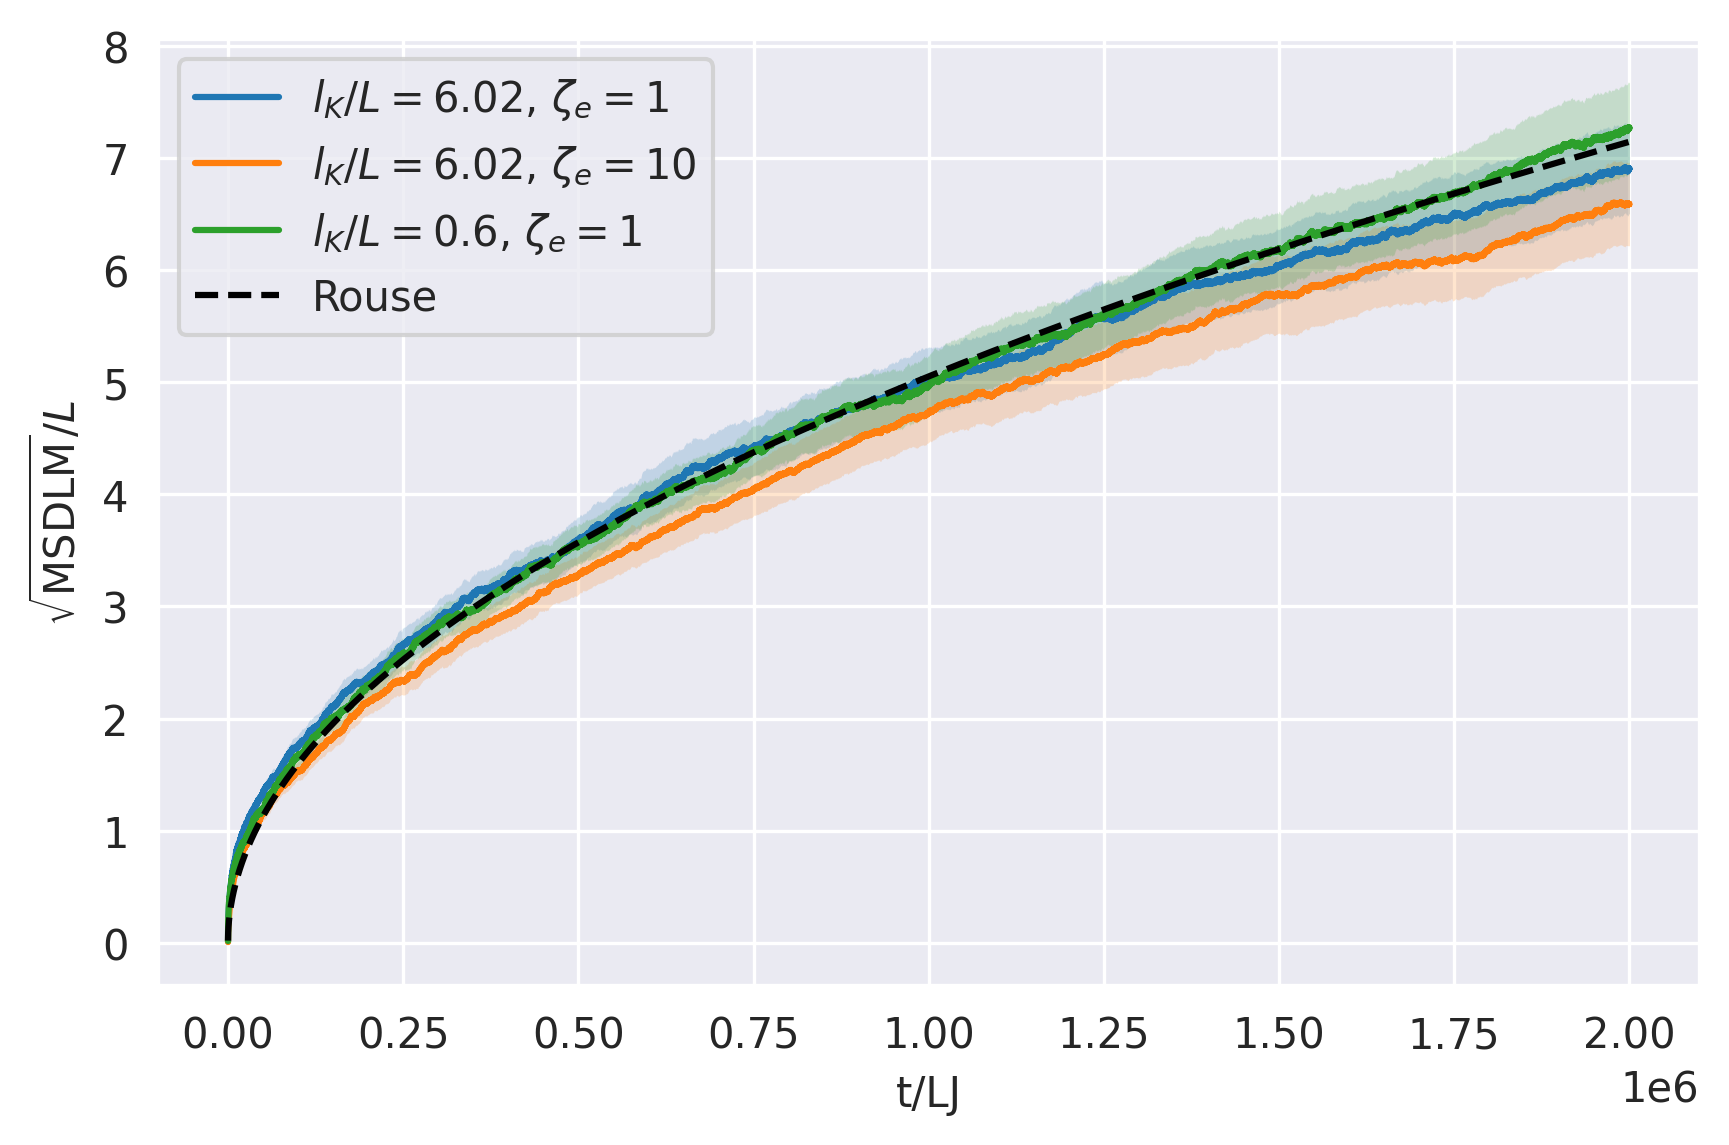

In [48]:
fig, ax = plt.subplots()

for experiment, color in zip(experiments, sns.color_palette()):
        
    print(f"Plotting {experiment['n']} ...")
    
    msd_plot.plot_MSD(
        experiment["df_msdlm"],
        log_scale=False,
        l_K=experiment["l_K"],
        L_contour=L_contour,
        zeta=zeta,
        zeta_e=experiment["zeta_e"],
        col="dr_N^2",
        label=experiment["label"],
        ax=ax,
        title="",
        ylabel="",
        xlabel="",
        scatter=False,
        marker_size=2,
        color=color
    )

ax.plot(df_rouse_msdlm["t/LJ"], np.sqrt(df_rouse_msdlm["dr_N^2"]) / L_contour, label="Rouse", linestyle="--", color="black")

ax.set(xlabel="t/LJ", ylabel="$\sqrt{\\mathrm{MSDLM}}/L$")
    
ax.legend(loc="upper left")

Plotting 17 ...
Plotting 18 ...
Plotting 19 ...


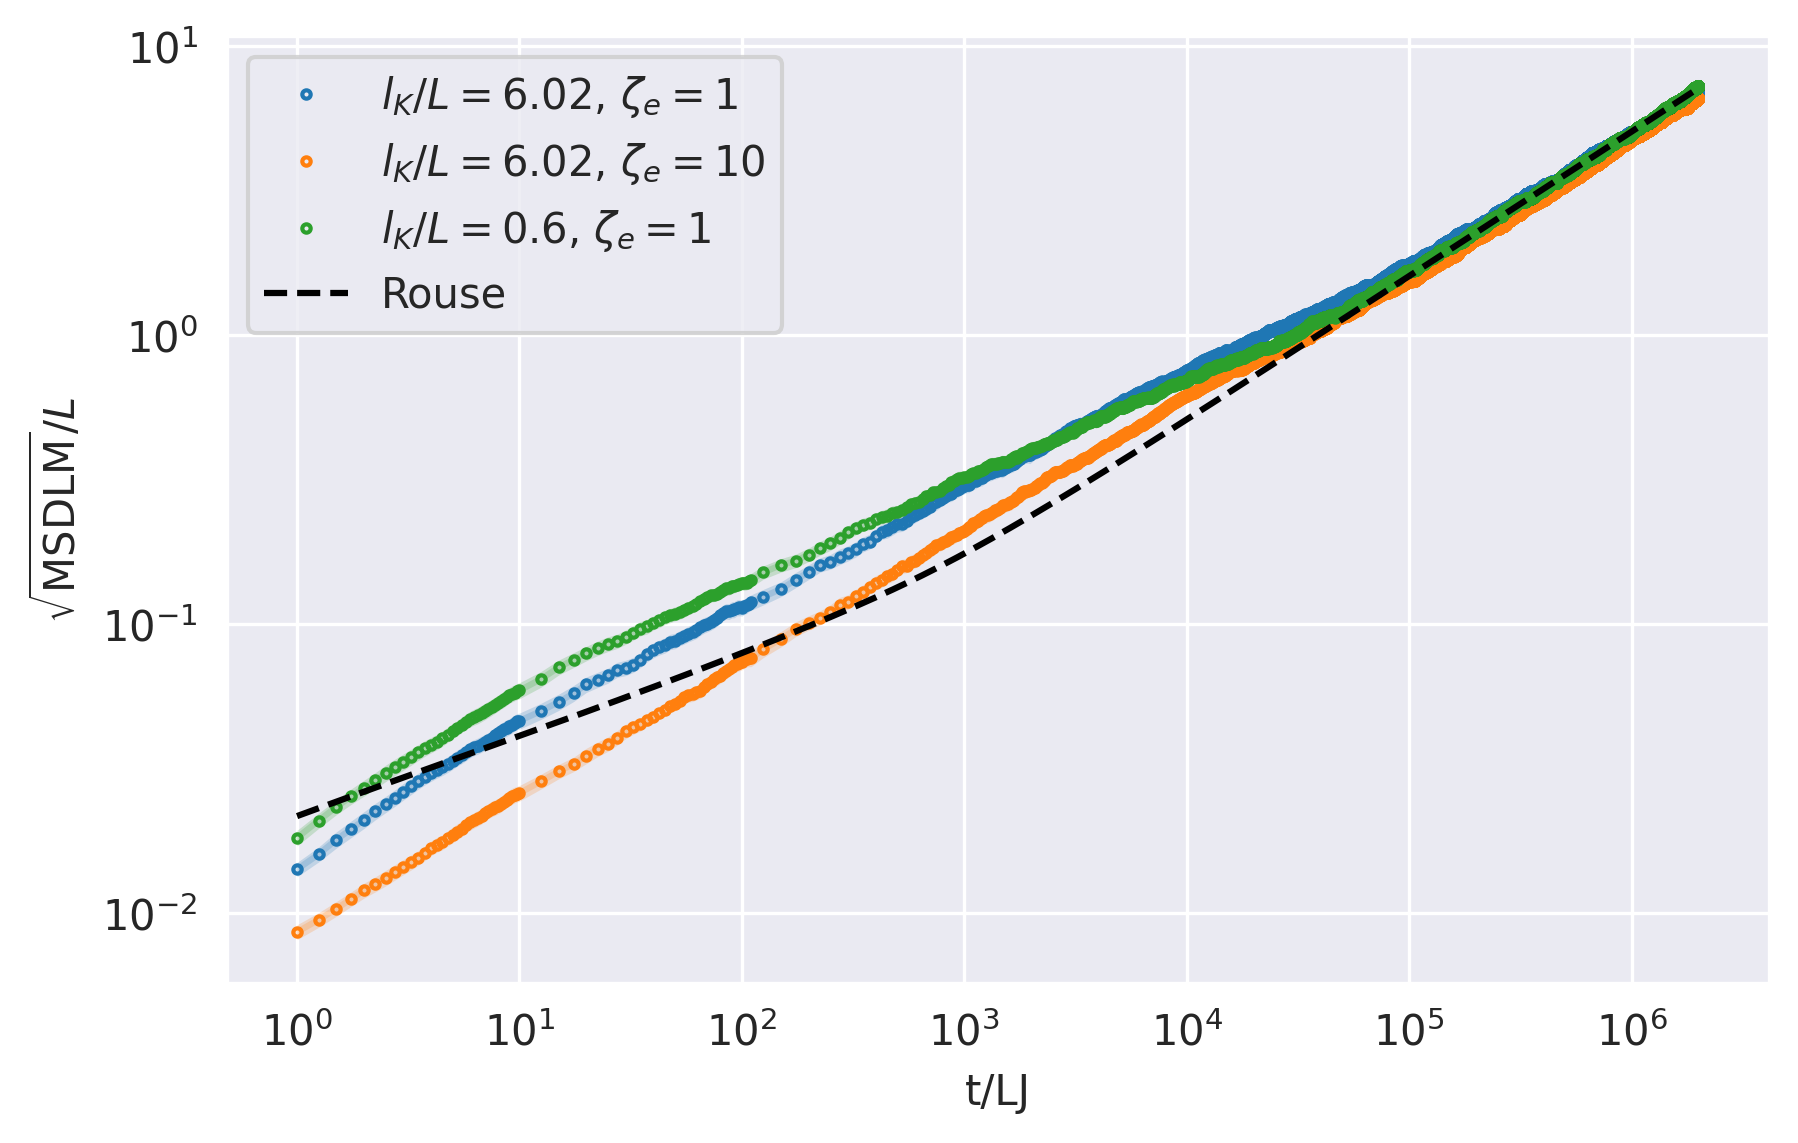

In [49]:
fig, ax = plt.subplots()

for experiment, color in zip(experiments, sns.color_palette()):
        
    print(f"Plotting {experiment['n']} ...")
    
    msd_plot.plot_MSD(
        experiment["df_msdlm"],
        log_scale=True,
        l_K=experiment["l_K"],
        L_contour=L_contour,
        zeta=zeta,
        zeta_e=experiment["zeta_e"],
        col="dr_N^2",
        label=experiment["label"],
        ax=ax,
        title="",
        ylabel="",
        xlabel="",
        scatter=True,
        marker_size=2,
        color=color
    )

ax.plot(df_rouse_msdlm["t/LJ"], np.sqrt(df_rouse_msdlm["dr_N^2"]) / L_contour, label="Rouse", linestyle="--", color="black")

ax.set(xlabel="t/LJ", ylabel="$\sqrt{\\mathrm{MSDLM}}/L$")
    
ax.legend(loc="upper left")

In [67]:
n_bins = 12
bins = None
#bins = np.logspace(np.log10(1400), np.log10(2e6), num=n_bins, base=10).tolist()
#bins = [1, 325] + bins
#print(bins)

for experiment in experiments:
    experiment["alpha"] = transform_msdlm.calculate_msd_alpha_df(experiment["df_msdlm"], bins=bins, n_bins=n_bins)

alpha_rouse = transform_msdlm.calculate_msd_alpha_df(df_rouse_msdlm, bins=bins, n_bins=n_bins)

experiments[0]["alpha"]

,alpha,delta alpha,delta t,interval,count
t/LJ,,,,,
1.00,1.129023,0.046972,1.250,"(1.0, 3.5)",11
3.75,0.904451,0.037174,4.375,"(3.75, 12.5)",27
15.00,0.823889,0.038964,17.500,"(15.0, 50.0)",15
52.50,0.779821,0.042115,61.250,"(52.5, 175.0)",27
200.00,0.819333,0.029749,262.500,"(200.0, 725.0)",22
750.00,0.809612,0.015793,987.500,"(750.0, 2725.0)",80
2750.00,0.807300,0.007179,3737.500,"(2750.0, 10225.0)",300
10250.00,0.735616,0.003641,13987.500,"(10250.0, 38225.0)",1120
38250.00,0.775336,0.001916,52375.000,"(38250.0, 143000.0)",4191


Text(0.02, 0.5, '$\\alpha$')

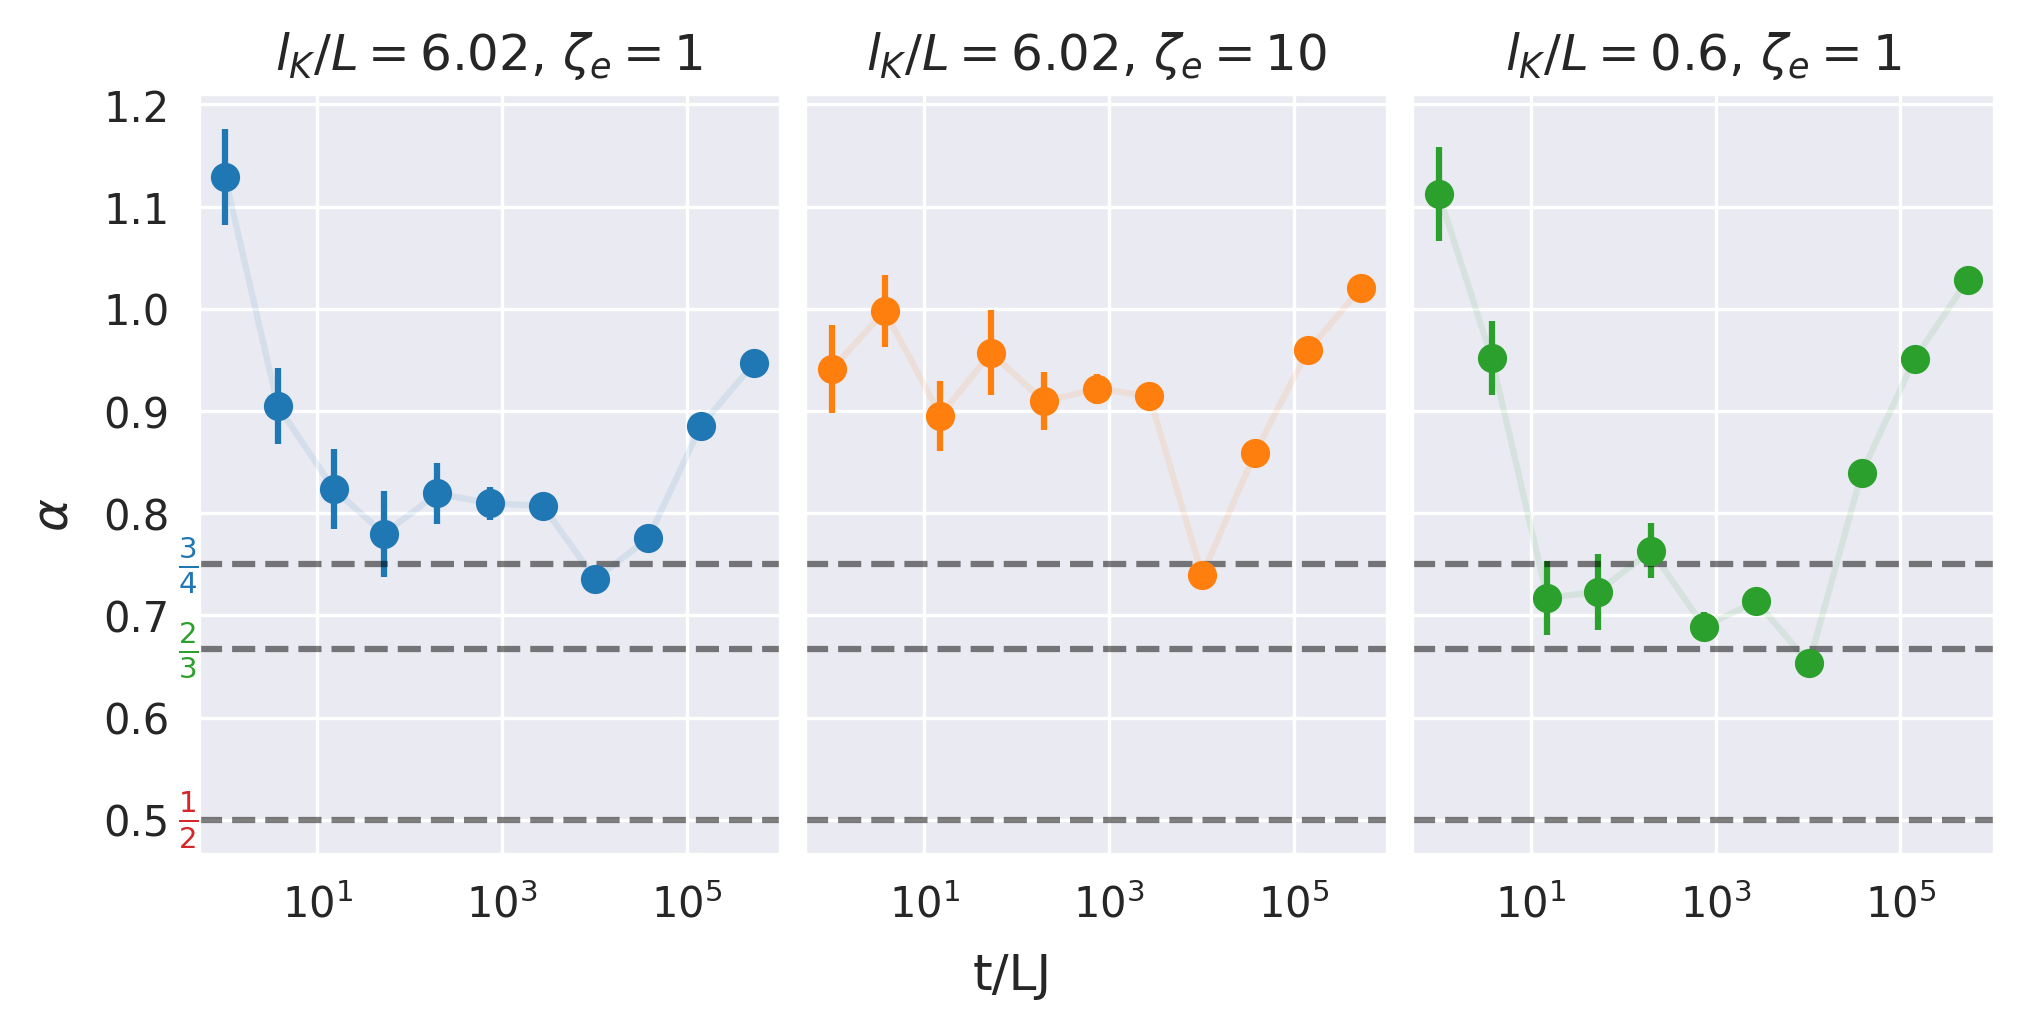

In [68]:
ax: plt.Axes
fig, axs = plt.subplots(
    ncols=3, 
    figsize=plot_utils.get_figure_size(
        width=1.0,
        n_rows=1,
        height=0.5
    ), 
    sharex="all", 
    sharey="all",
    layout="constrained"
)

for color, experiment, ax in zip(sns.color_palette(), experiments, axs):
    ax.errorbar(
        experiment["alpha"].index, 
        y=experiment["alpha"]["alpha"], 
        yerr=experiment["alpha"]["delta alpha"],
        label=experiment["label"], 
        color=color,
        marker = "o",
        linestyle="none",
    )
    ax.plot(experiment["alpha"].index, experiment["alpha"]["alpha"], color=color, alpha=0.1)
    ax.set(xscale="log", title=experiment["label"])
    
    ax.axhline(y=2 / 3, color="black", linestyle="--", alpha=0.5)
    ax.axhline(y=3 / 4, color="black", linestyle="--", alpha=0.5)
    ax.axhline(y=1 / 2, color="black", linestyle="--", alpha=0.5)

#axs[-1].plot(alpha_rouse.index, alpha_rouse["alpha"], linestyle="-", label="Rouse", color="red")


import matplotlib.transforms as transforms
trans = transforms.blended_transform_factory(
    axs[0].get_yticklabels()[0].get_transform(), 
    axs[0].transData
)

axs[0].text(
    0.05, 
    2/3, 
    "$\\frac{2}{3}$", 
    color=sns.color_palette()[2], 
    transform=trans, 
    ha="right", 
    va="center"
)

axs[0].text(
    0.05, 
    3/4, 
    "$\\frac{3}{4}$", 
    color=sns.color_palette()[0], 
    transform=trans, 
    ha="right", 
    va="center"
)

axs[0].text(
    0.05, 
    1/2, 
    "$\\frac{1}{2}$", 
    color=sns.color_palette()[3], 
    transform=trans, 
    ha="right", 
    va="center"
)
#ax.legend()
fig.supxlabel("t/LJ")
fig.supylabel("$\\alpha$")